In [ ]:
!pip install ultralytics==8.0.196

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 30.0/78.2 GB disk)


In [ ]:
from ultralytics import YOLO
from IPython.display import Image, clear_output
!pip install roboflow
clear_output()

In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="TR2n5JTcwaRKLAU3sNDd", model_format="yolov8")
dataset = rf.workspace().project("mil_target").version(1).download(location="/content/my-datasets")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to /content/my-datasets in yolov8:: 100%|██████████| 142/142 [00:00<00:00, 6578.57it/s]


In [ ]:
%cd {HOME}
!yolo task=detect mode=train model=yolov8s.pt data={dataset.location}/data.yaml epochs=30 imgsz=512 plots=True

[Errno 2] No such file or directory: '{HOME}'
/content
100% 21.5M/21.5M [00:00<00:00, 81.0MB/s]
New https://pypi.org/project/ultralytics/8.2.26 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/my-datasets/data.yaml, epochs=30, patience=50, batch=16, imgsz=512, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, sho

[Errno 2] No such file or directory: '{content}'
/content


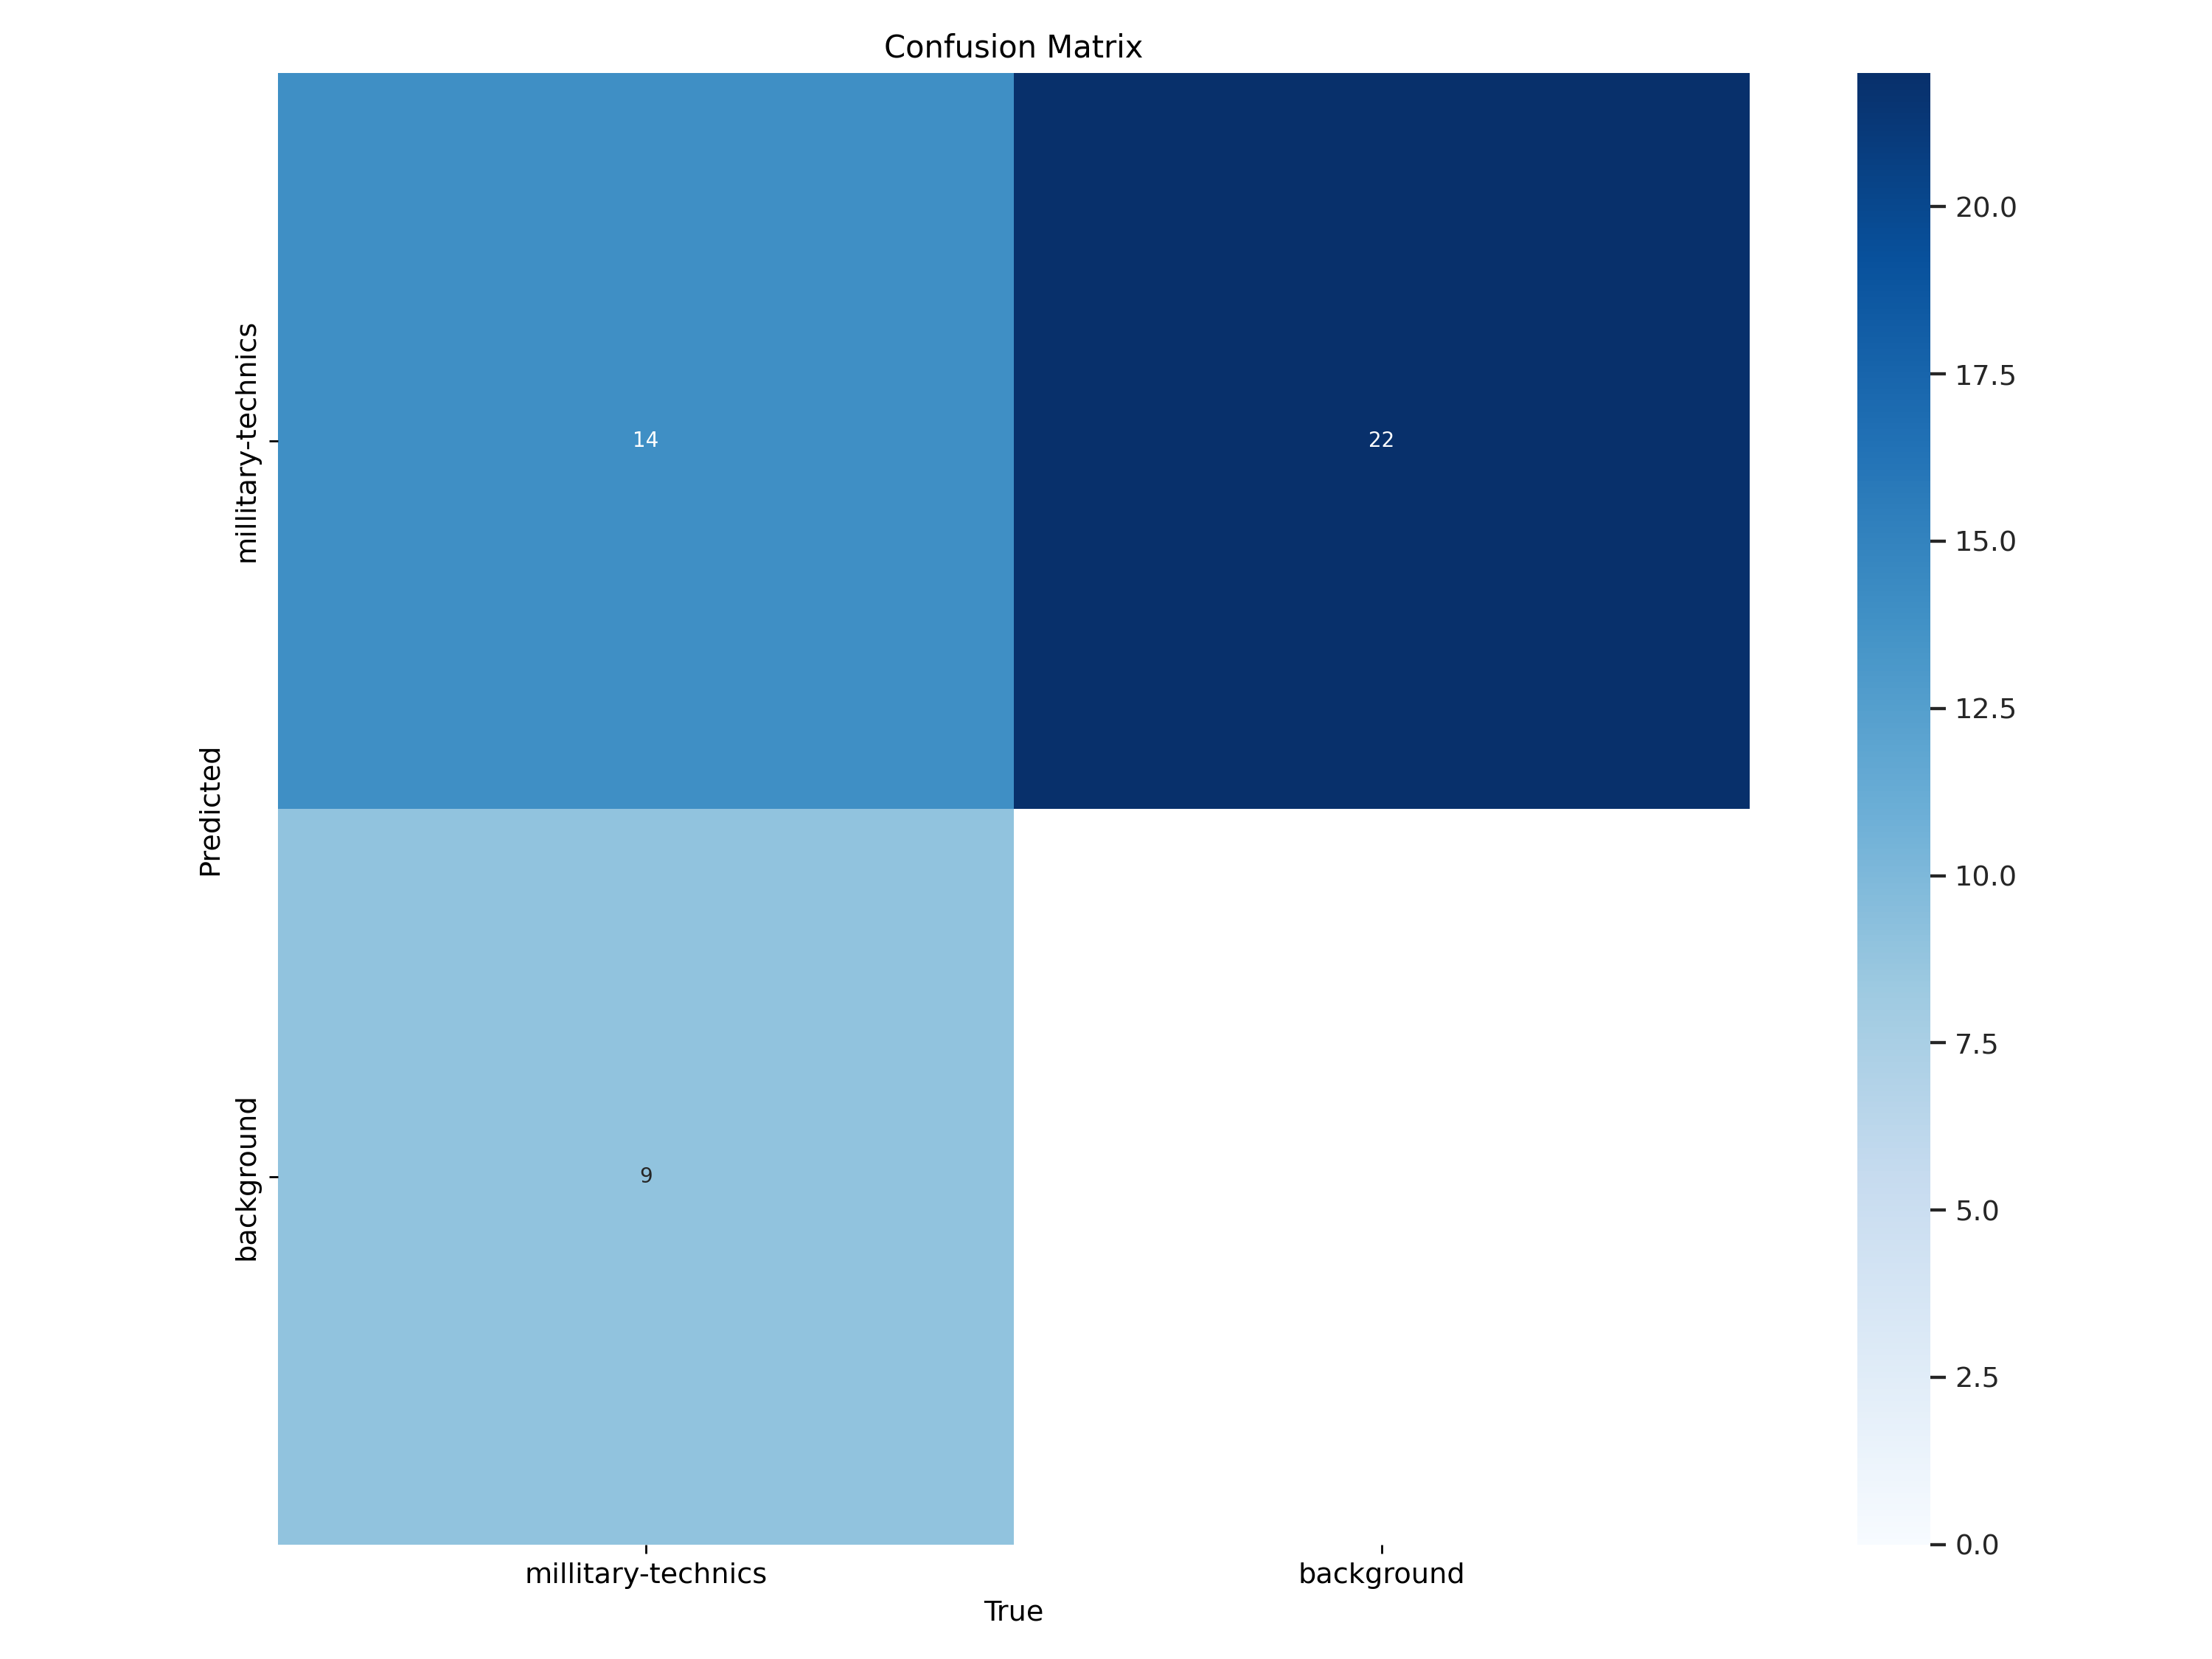

In [ ]:
%cd {content}
Image(filename=f'/content/runs/detect/train/confusion_matrix.png', width=1200)

[Errno 2] No such file or directory: '{content}'
/content


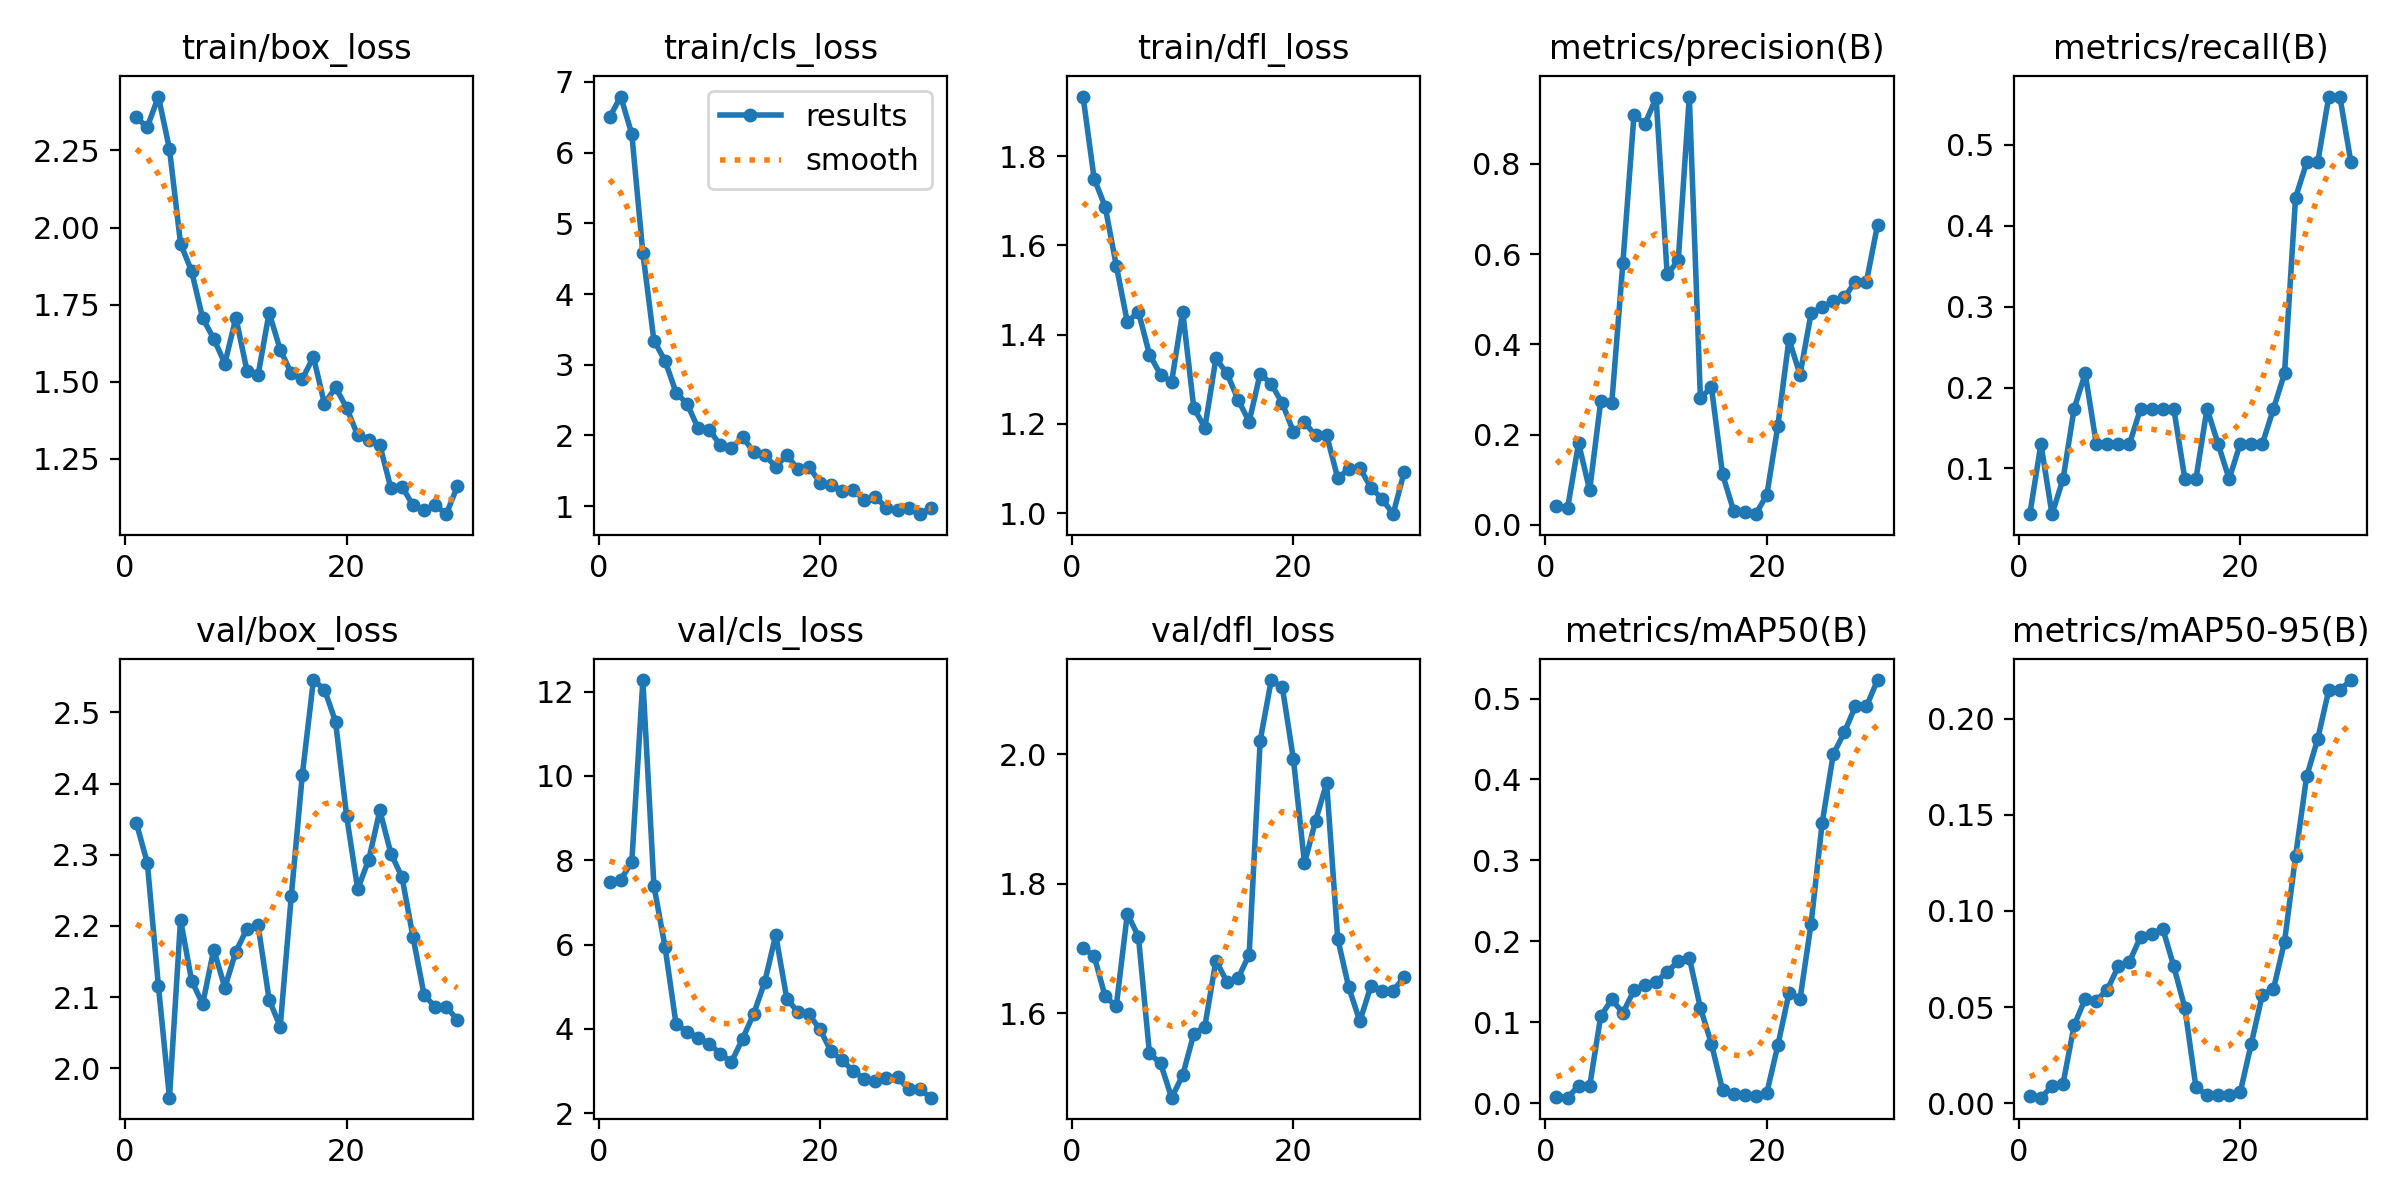

In [ ]:
%cd {content}
Image(filename=f'/content/runs/detect/train/results.png', width=1200)

[Errno 2] No such file or directory: '{content}'
/content


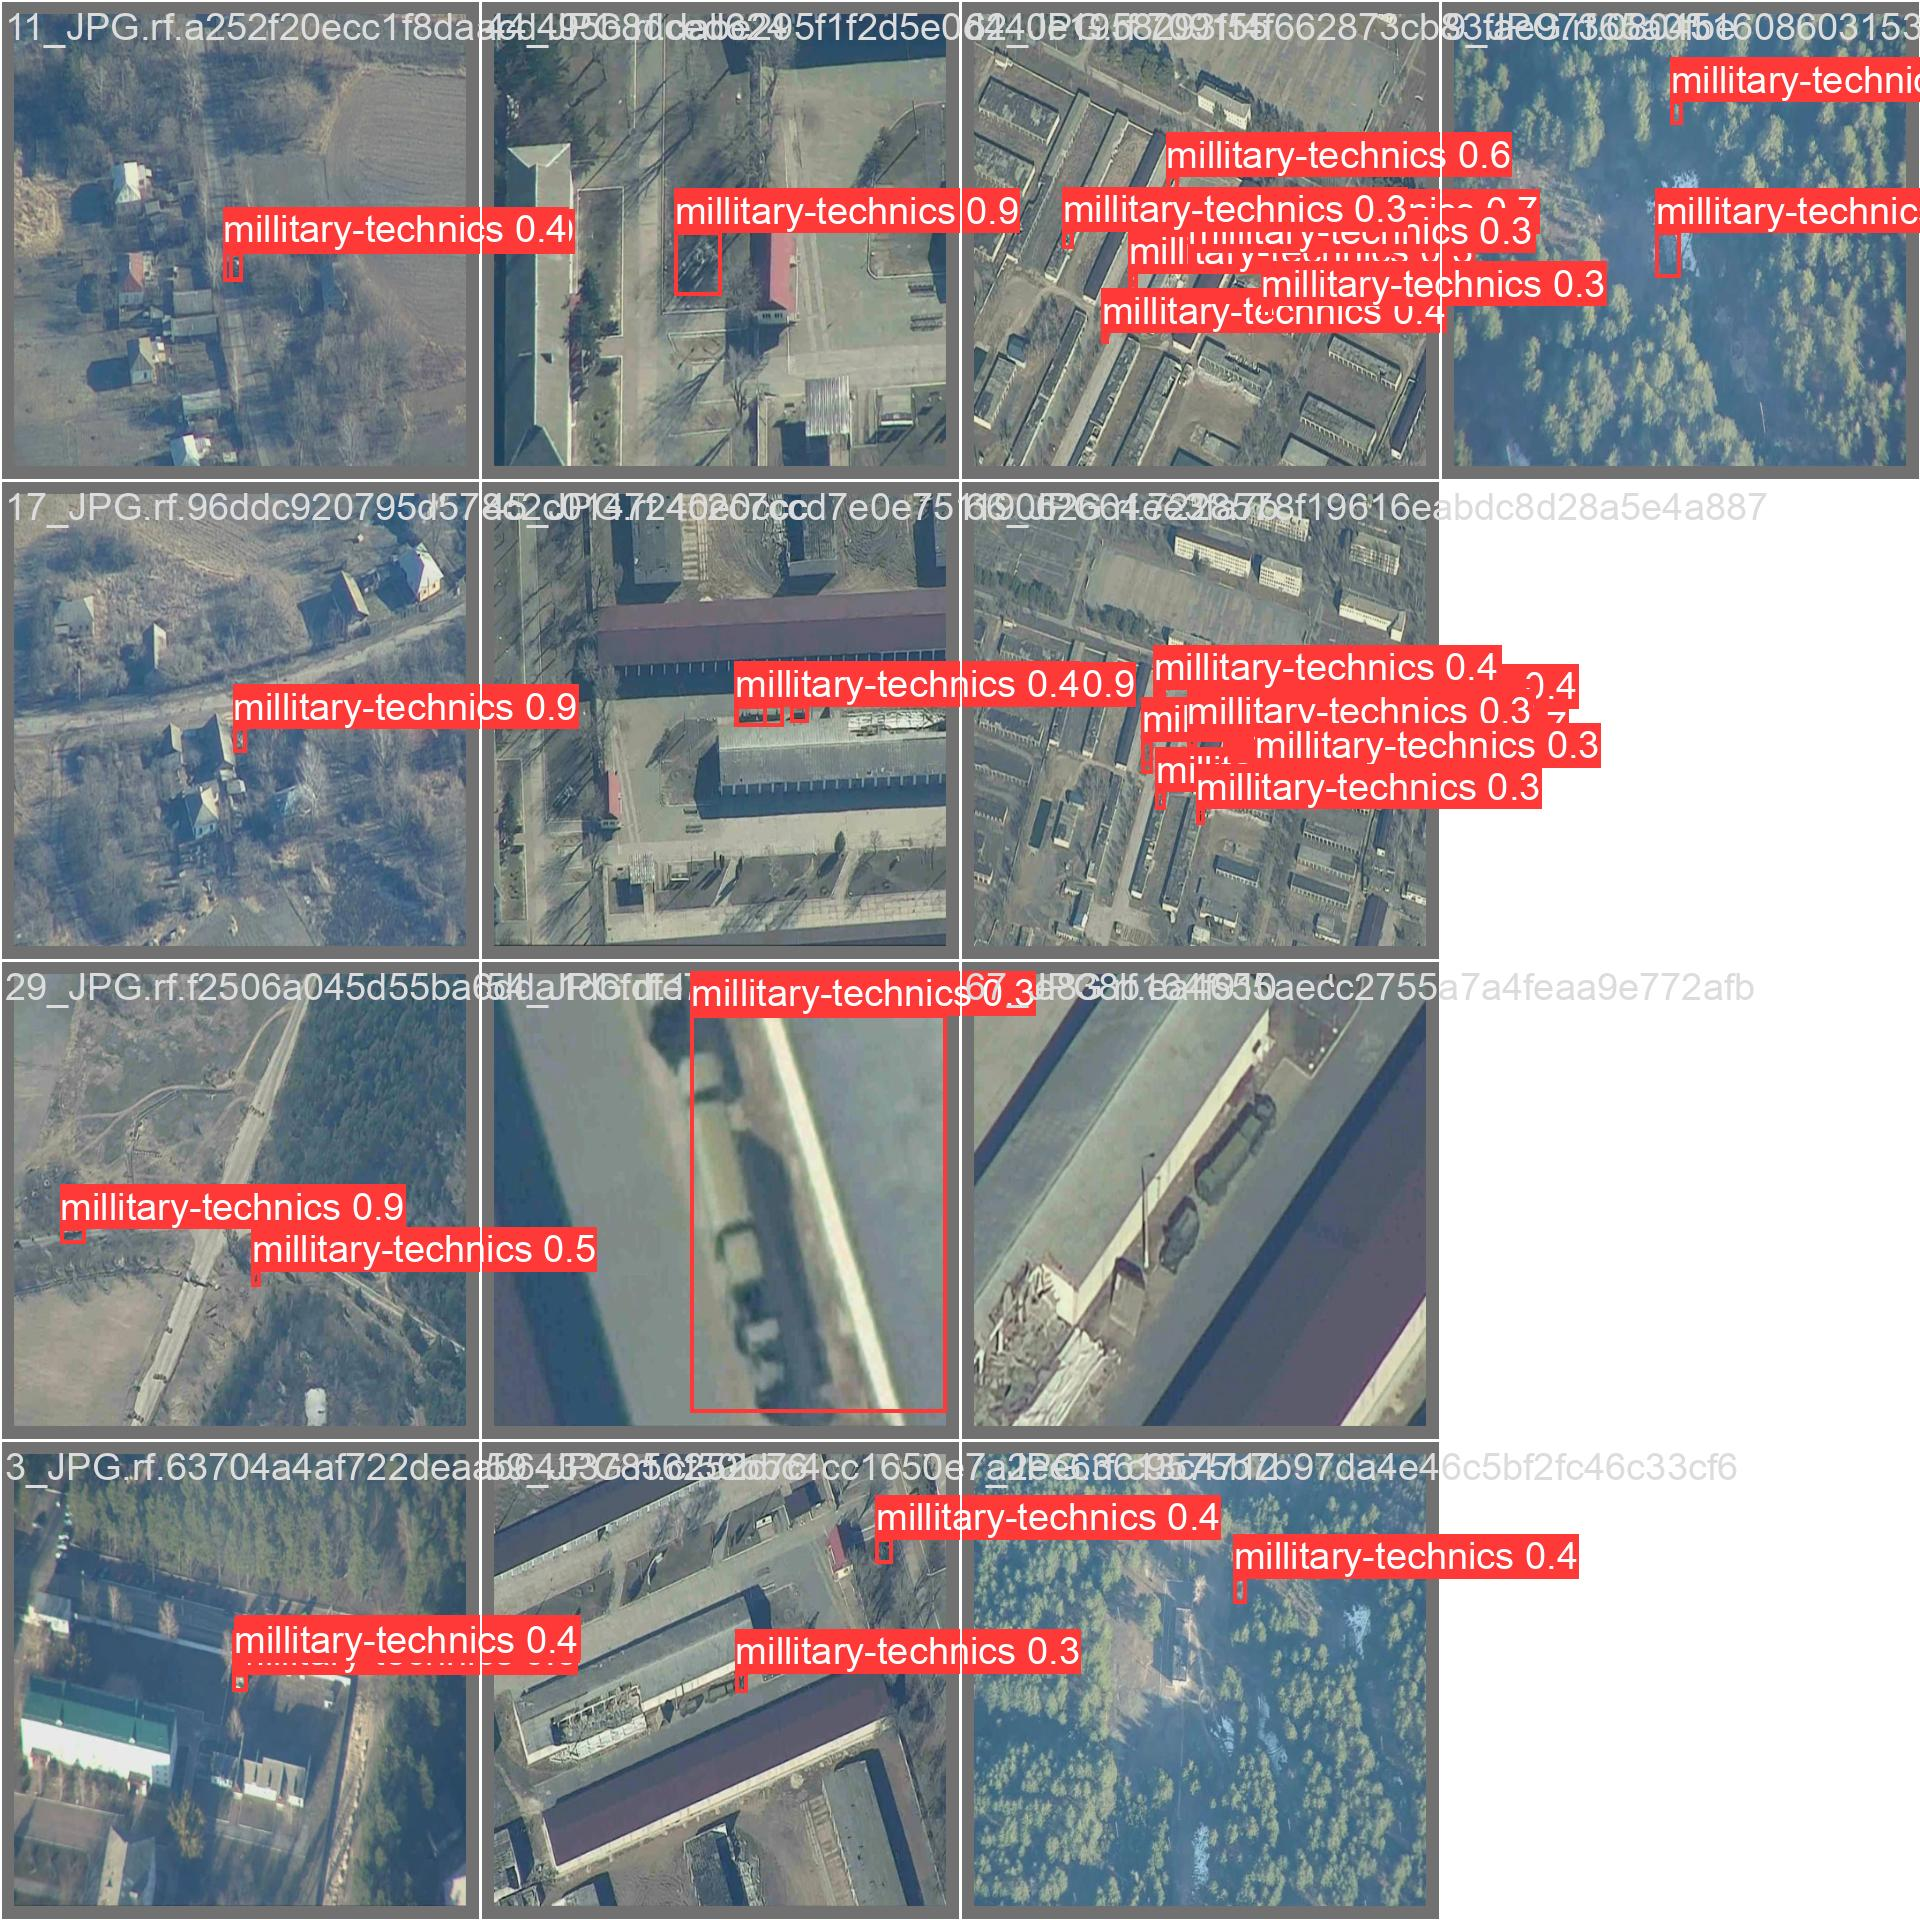

In [ ]:
%cd {content}
Image(filename=f'/content/runs/detect/train/val_batch0_pred.jpg', width=1200)

In [ ]:
!pip install ultralytics

In [ ]:
!pip install Shapely

In [ ]:
import cv2
import numpy as np
from shapely.geometry import Point
from ultralytics import YOLO
from ultralytics.solutions import QueueManager
from ultralytics.utils.plotting import Annotator, colors



ModuleNotFoundError: No module named 'ultralytics.solutions'

In [ ]:
class MyQueueManager(QueueManager):
    """

    Этот класс наследует функции класса QueueManager и
    изменяет текст вывода на экране.
    После обработки треков он отображает количество птиц на экране.

    """

    def extract_and_process_tracks(self, tracks):
        """Извлекает и обрабатывает треки в видео-потоке."""

        # Инициализируется аннотатор
        self.annotator = Annotator(self.im0, self.tf, self.names)

        if tracks[0].boxes.id is not None:
            boxes = tracks[0].boxes.xyxy.cpu()
            clss = tracks[0].boxes.cls.cpu().tolist()
            track_ids = tracks[0].boxes.id.int().cpu().tolist()

            # Извлекаются треки
            for box, track_id, cls in zip(boxes, track_ids, clss):
                # Изображаются bounding boxes
                self.annotator.box_label(
                    box,
                    label=f"{self.names[cls]}#{track_id}",
                    color=colors(int(track_id), True),
                )

                # Обновляется история треков
                track_line = self.track_history[track_id]
                track_line.append(
                    (float((box[0] + box[2]) / 2),
                     float((box[1] + box[3]) / 2))
                )
                if len(track_line) > 30:
                    track_line.pop(0)

                # Отрисовка следа, если необходимо
                if self.draw_tracks:
                    self.annotator.draw_centroid_and_tracks(
                        track_line,
                        color=self.track_color or colors(int(track_id), True),
                        track_thickness=self.track_thickness,
                    )

                prev_position = (
                    self.track_history[track_id][-2]
                    if len(self.track_history[track_id]) > 1
                    else None
                )

                # Проверка, находится ли объект внутри области подсчета
                if len(self.reg_pts) >= 3:
                    is_inside = (self.counting_region
                                 .contains(Point(track_line[-1])))
                    if prev_position is not None and is_inside:
                        self.counts += 1

        # Вывод на экран счетчика птиц
        label = f"Number target : {str(self.counts)}"
        if label is not None:
            self.annotator.queue_counts_display(
                label,
                points=self.reg_pts,
                region_color=self.region_color,
                txt_color=self.count_txt_color,
            )

        # Сброс счетчика после вывода на экран
        self.counts = 0
        self.display_frames()


In [ ]:
model = YOLO("yolov8s.pt")
cap = cv2.VideoCapture("8.mp4")

assert cap.isOpened(), "Ошибка при чтении видео-файла"
w, h, fps = (
    int(cap.get(x))
    for x in (cv2.CAP_PROP_FRAME_WIDTH,
              cv2.CAP_PROP_FRAME_HEIGHT,
              cv2.CAP_PROP_FPS)
)

video_writer = cv2.VideoWriter(
    "test_result.avi", cv2.VideoWriter_fourcc(*"mp4v"), fps, (w, h)
)


ZONE_POLYGON = np.array([[0, 0], [1, 0], [1, 1], [0, 1]])

# Определяем область для подсчета объектов на все кадре
zone_polygon = (ZONE_POLYGON * np.array([w, h])).astype(int)

queue = MyQueueManager(
    classes_names=model.names,
    reg_pts=zone_polygon,
    line_thickness=3,
    fontsize=1.0,
    region_color=(255, 144, 31),
)

while cap.isOpened():
    success, im0 = cap.read()
    if not success:
        print("Видео пустое или обработка видео успешно завершена.")
        break

    tracks = model.track(im0, show=False, persist=True, verbose=False)
    out = queue.process_queue(im0, tracks)

    video_writer.write(im0)


cap.release()
cv2.destroyAllWindows()